## Imports

In [45]:
%load_ext lab_black
import pandas as pd
import numpy as np
from sdv.metadata import SingleTableMetadata
from sdv.single_table import (
    CTGANSynthesizer,
    TVAESynthesizer,
    GaussianCopulaSynthesizer,
    CopulaGANSynthesizer,
)
from sdv.lite import SingleTablePreset
from sdv.evaluation.single_table import (
    evaluate_quality,
    get_column_plot,
    get_column_pair_plot,
)
import warnings
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
import time

sns.set(style="darkgrid", font_scale=0.5)
custom_palette = ["#8b4513", "#90ee90", "#545454", "#6a287e", "#f0be00"]
sns.set_palette(custom_palette)

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    StratifiedKFold,
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report,
    roc_auc_score,
    f1_score,
    precision_score,
)

warnings.filterwarnings("ignore")

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


## Funções

In [46]:
def dummy(df, columns):
    dummy_variables = []
    for column in columns:
        dummies = pd.get_dummies(df[column], prefix=column)
        dummy_variables.append(dummies)
    return dummy_variables

In [47]:
def evaluate_models(X_train, X_test, y_train, y_test, standardscaler=True):
    if standardscaler:
        scaler = StandardScaler().fit(X_train)
    else:
        scaler = MinMaxScaler().fit(X_train)

    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    models = [
        ("SVM", SVC(), {"C": [0.1, 0.5, 1, 5, 10], "kernel": ["linear", "rbf"]}),
        (
            "Decision Tree",
            DecisionTreeClassifier(),
            {"max_depth": [None, 1, 2, 5, 10], "min_samples_split": [2, 3, 4, 5, 10]},
        ),
        (
            "KNN",
            KNeighborsClassifier(),
            {"n_neighbors": [1, 2, 3, 4, 5, 7, 10], "weights": ["uniform", "distance"]},
        ),
        (
            "Random Forest",
            RandomForestClassifier(),
            {"n_estimators": [100, 200, 300], "max_depth": [None, 5, 10]},
        ),
        (
            "Logistic Regression",
            LogisticRegression(max_iter=1000),
            {"C": [0.1, 0.5, 1, 5, 10], "solver": ["liblinear", "sag", "saga"]},
        ),
        (
            "MLP",
            MLPClassifier(max_iter=1000),
            {"hidden_layer_sizes": [(100,), (100, 50)], "alpha": [0.0001, 0.001, 0.01]},
        ),
    ]

    results = []

    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for name, model, param_grid in models:
        start_time = time.time()

        clf = GridSearchCV(model, param_grid, cv=stratified_cv)
        clf.fit(X_train_scaled, y_train)

        best_model = clf.best_estimator_
        best_params = clf.best_params_

        y_pred = best_model.predict(X_test_scaled)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)

        execution_time = time.time() - start_time

        results.append(
            {
                "Classificador": name,
                "Acurácia": accuracy,
                "Precisão": precision,
                "F1 Score": f1,
                "ROC/AUC": roc_auc,
                "Tempo": execution_time,
                "Best Parameters": best_params,
            }
        )

    results_df = pd.DataFrame(results)
    return results_df

In [48]:
def plot_confusion_matrix(model, y_pred, y_test):
    cm = confusion_matrix(y_test, y_pred)
    classes = np.unique(y_test)

    fig = sp.make_subplots(rows=1, cols=1)

    fig.add_trace(
        go.Heatmap(
            z=cm,
            x=classes,
            y=classes,
            colorscale="Blues",
            reversescale=True,
            showscale=False,
            hoverongaps=False,
            hovertemplate="Actual: %{y}Predicted: %{x}Count: %{z}",
        )
    )

    annotations = []
    for i in range(len(classes)):
        for j in range(len(classes)):
            annotations.append(
                dict(
                    x=classes[j],
                    y=classes[i],
                    text=str(cm[i, j]),
                    showarrow=False,
                    font=dict(color="black"),
                )
            )

    fig.update_layout(
        title="Confusion Matrix", width=600, height=500, annotations=annotations
    )

    fig.update_xaxes(title_text="Predicted")
    fig.update_yaxes(title_text="Actual")

    fig.show()

## Dataset Analysis

In [115]:
df = pd.read_csv("heart_cleveland.csv")
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,40,1,3,152,223,0,0,181,0,0.0,0,0,2,1
293,39,1,3,118,219,0,0,140,0,1.2,1,0,2,1
294,35,1,3,120,198,0,0,130,1,1.6,1,0,2,1
295,35,0,3,138,183,0,0,182,0,1.4,0,0,0,0


### Informações Gerais sobre o Dataset

| Nome do Atributo | Papel | Tipo | Descrição | Unidades |
| --- | --- | --- | --- | --- |
| age | Feature | Discreto | Idade | anos |
| sex | Feature | Categórico | Sexo | 1 = masculino, 0 = feminino |
| cp | Feature | Categórico | Tipo de Dor no Peito | 0 = angina típica; 1 = angina atípica; 2 = dor não anginosa; 3 = assintomático |
| trestbps | Feature | Discreto | Pressão Arterial de Repouso (na admissão ao hospital) | mm Hg |
| chol | Feature | Discreto | Colesterol Sérico | mg/dl |
| fbs | Feature | Categórico | Açúcar no Sangue em Jejum > 120 mg/dl | 1 = true; 0 = false |
| restecg | Feature | Categórico | Eletrocardiograma de Repouso | 0 = normal; 1 = anormalidade na onda ST-T; 2 = hipertrofia ventricular esquerda |
| thalach | Feature | Discreto | Frequência Cardíaca Máxima Atingida | Hz |
| exang | Feature | Categórico | Angina Induzida por Exercício | 1 = true; 0 = false |
| oldpeak | Feature | Discreto | Depressão de ST Induzida por Exercício em Relação ao Repouso | float |
| slope | Feature | Categórico | Inclinação do Segmento ST de Pico do Exercício | 0 = ascendente; 1 = plano; 2 = descendente |
| ca | Feature | Discreto | Número de Vasos Principais coloridos por Fluoroscopia | 0-3 |
| thal | Feature | Categórico | Classificação da Frequência Cardíaca Máxima Atingida | 0 = normal; 1 = defeito fixo; 2 = defeito reversível |
| condition | Label | Categórico | Condição | 0 = sem doença; 1 = doença |


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


In [51]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,297.0,54.542088,9.049736,29.0,48.0,56.0,61.0,77.0
sex,297.0,0.676768,0.468500,0.0,0.0,1.0,1.0,1.0
cp,297.0,2.158249,0.964859,0.0,2.0,2.0,3.0,3.0
trestbps,297.0,131.693603,17.762806,94.0,120.0,130.0,140.0,200.0
chol,297.0,247.350168,51.997583,126.0,211.0,243.0,276.0,564.0
fbs,297.0,0.144781,0.352474,0.0,0.0,0.0,0.0,1.0
restecg,297.0,0.996633,0.994914,0.0,0.0,1.0,2.0,2.0
thalach,297.0,149.599327,22.941562,71.0,133.0,153.0,166.0,202.0
exang,297.0,0.326599,0.469761,0.0,0.0,0.0,1.0,1.0
oldpeak,297.0,1.055556,1.166123,0.0,0.0,0.8,1.6,6.2


## Pre-processamento utilizando OneHotEncoder

In [52]:
cat_features = ["sex", "restecg", "slope", "cp", "exang", "thal", "ca", "fbs"]
num_features = ["age", "oldpeak", "trestbps", "thalach", "chol"]

In [53]:
dummy_variables = dummy(df, cat_features)
df = pd.concat([df] + dummy_variables, axis=1)
df = df.drop(cat_features, axis=1)

In [54]:
df

,age,trestbps,chol,thalach,oldpeak,condition,sex_0,sex_1,restecg_0,restecg_1,...,exang_1,thal_0,thal_1,thal_2,ca_0,ca_1,ca_2,ca_3,fbs_0,fbs_1
0,69,160,234,131,0.1,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
1,69,140,239,151,1.8,0,1,0,1,0,...,0,1,0,0,0,0,1,0,1,0
2,66,150,226,114,2.6,0,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0
3,65,138,282,174,1.4,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
4,64,110,211,144,1.8,0,0,1,0,0,...,1,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,40,152,223,181,0.0,1,0,1,1,0,...,0,0,0,1,1,0,0,0,1,0
293,39,118,219,140,1.2,1,0,1,1,0,...,0,0,0,1,1,0,0,0,1,0
294,35,120,198,130,1.6,1,0,1,1,0,...,1,0,0,1,1,0,0,0,1,0
295,35,138,183,182,1.4,0,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0


## Divisão Treino e Teste

In [12]:
y = df["condition"]
X = df.drop("condition", axis=1)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

In [14]:
print(
    f"X_train: {X_train.shape} \nX_test: {X_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}"
)

X_train: (207, 28) 
X_test: (90, 28) 
y_train: (207,) 
y_test: (90,)


## Avaliação dos Modelos sem Dados Incrementados

In [15]:
results_df = evaluate_models(X_train, X_test, y_train, y_test, standardscaler=False)
print(results_df)

         Classificador  Acurácia  Precisão  F1 Score   ROC/AUC      Tempo  \
0                  SVM  0.822222  0.809524  0.809524  0.821429   0.164689   
1        Decision Tree  0.744444  0.711111  0.735632  0.745536   0.202527   
2                  KNN  0.855556  0.822222  0.850575  0.857143   3.653552   
3        Random Forest  0.788889  0.767442  0.776471  0.788690  11.503821   
4  Logistic Regression  0.833333  0.787234  0.831461  0.836310   0.326268   
5                  MLP  0.866667  0.826087  0.863636  0.869048  10.627049   

                                     Best Parameters  
0                        {'C': 0.1, 'kernel': 'rbf'}  
1           {'max_depth': 1, 'min_samples_split': 2}  
2           {'n_neighbors': 5, 'weights': 'uniform'}  
3             {'max_depth': 10, 'n_estimators': 100}  
4                    {'C': 5, 'solver': 'liblinear'}  
5  {'alpha': 0.0001, 'hidden_layer_sizes': (100, ...  


### Melhor Modelo sem os Dados Incrementados: KNN

## Criando os Dados Sintetizados

In [102]:
df = pd.read_csv("heart_cleveland.csv")
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,40,1,3,152,223,0,0,181,0,0.0,0,0,2,1
293,39,1,3,118,219,0,0,140,0,1.2,1,0,2,1
294,35,1,3,120,198,0,0,130,1,1.6,1,0,2,1
295,35,0,3,138,183,0,0,182,0,1.4,0,0,0,0


In [103]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df)
metadata

{
    "columns": {
        "age": {
            "sdtype": "numerical"
        },
        "sex": {
            "sdtype": "numerical"
        },
        "cp": {
            "sdtype": "numerical"
        },
        "trestbps": {
            "sdtype": "numerical"
        },
        "chol": {
            "sdtype": "numerical"
        },
        "fbs": {
            "sdtype": "numerical"
        },
        "restecg": {
            "sdtype": "numerical"
        },
        "thalach": {
            "sdtype": "numerical"
        },
        "exang": {
            "sdtype": "numerical"
        },
        "oldpeak": {
            "sdtype": "numerical"
        },
        "slope": {
            "sdtype": "numerical"
        },
        "ca": {
            "sdtype": "numerical"
        },
        "thal": {
            "sdtype": "numerical"
        },
        "condition": {
            "sdtype": "numerical"
        }
    },
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1"
}

In [104]:
# check errors

metadata.validate()

- cat_features = ["sex", "restecg", "slope", "cp", "exang", "thal", "ca", "fbs"]
- num_features = ["age", "oldpeak", "trestbps", "thalach", "chol"]

In [105]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,40,1,3,152,223,0,0,181,0,0.0,0,0,2,1
293,39,1,3,118,219,0,0,140,0,1.2,1,0,2,1
294,35,1,3,120,198,0,0,130,1,1.6,1,0,2,1
295,35,0,3,138,183,0,0,182,0,1.4,0,0,0,0


In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


In [107]:
metadata.update_column(
    column_name="age", sdtype="numerical", computer_representation="Int32"
)

metadata.update_column(
    column_name="oldpeak", sdtype="numerical", computer_representation="Float"
)

metadata.update_column(
    column_name="trestbps", sdtype="numerical", computer_representation="Int32"
)

metadata.update_column(
    column_name="thalach", sdtype="numerical", computer_representation="Int32"
)

metadata.update_column(
    column_name="chol", sdtype="numerical", computer_representation="Int32"
)

metadata.update_column(
    column_name="sex", sdtype="numerical", computer_representation="Int32"
)

metadata.update_column(
    column_name="restecg", sdtype="numerical", computer_representation="Int32"
)

metadata.update_column(
    column_name="slope", sdtype="numerical", computer_representation="Int32"
)

metadata.update_column(
    column_name="cp", sdtype="numerical", computer_representation="Int32"
)

metadata.update_column(
    column_name="exang", sdtype="numerical", computer_representation="Int32"
)

metadata.update_column(
    column_name="thal", sdtype="numerical", computer_representation="Int32"
)

metadata.update_column(
    column_name="ca", sdtype="numerical", computer_representation="Int32"
)

metadata.update_column(
    column_name="fbs", sdtype="numerical", computer_representation="Int32"
)

metadata.update_column(
    column_name="condition", sdtype="numerical", computer_representation="Int32"
)

In [108]:
metadata

{
    "columns": {
        "age": {
            "sdtype": "numerical",
            "computer_representation": "Int32"
        },
        "sex": {
            "sdtype": "numerical",
            "computer_representation": "Int32"
        },
        "cp": {
            "sdtype": "numerical",
            "computer_representation": "Int32"
        },
        "trestbps": {
            "sdtype": "numerical",
            "computer_representation": "Int32"
        },
        "chol": {
            "sdtype": "numerical",
            "computer_representation": "Int32"
        },
        "fbs": {
            "sdtype": "numerical",
            "computer_representation": "Int32"
        },
        "restecg": {
            "sdtype": "numerical",
            "computer_representation": "Int32"
        },
        "thalach": {
            "sdtype": "numerical",
            "computer_representation": "Int32"
        },
        "exang": {
            "sdtype": "numerical",
            "computer_representati

### Constraints

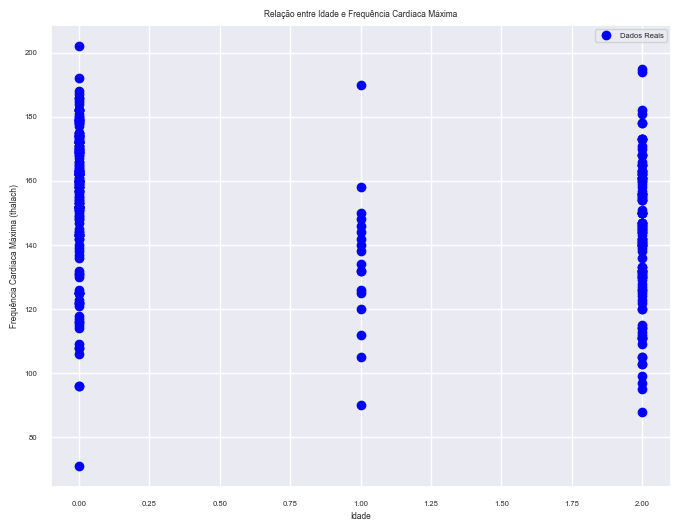

In [114]:
import matplotlib.pyplot as plt

# Dados reais do DataFrame df
age = df["thal"]
thalach = df["thalach"]

plt.figure(figsize=(8, 6))
plt.scatter(age, thalach, c="blue", marker="o", label="Dados Reais")
plt.xlabel("Idade")
plt.ylabel("Frequência Cardíaca Máxima (thalach)")
plt.title("Relação entre Idade e Frequência Cardíaca Máxima")
plt.legend()
plt.grid(True)
plt.show()

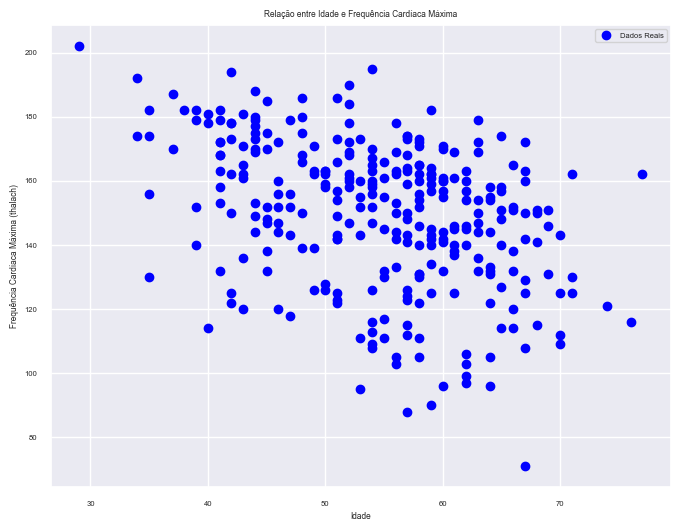

In [109]:
import matplotlib.pyplot as plt

# Dados reais do DataFrame df
age = df["age"]
thalach = df["thalach"]

plt.figure(figsize=(8, 6))
plt.scatter(age, thalach, c="blue", marker="o", label="Dados Reais")
plt.xlabel("Idade")
plt.ylabel("Frequência Cardíaca Máxima (thalach)")
plt.title("Relação entre Idade e Frequência Cardíaca Máxima")
plt.legend()
plt.grid(True)
plt.show()

- a depressão de ST induzida por exercício em relação ao repouso (oldpeak) deve ser menor ou igual à frequência cardíaca máxima (thalach)
- a pressão arterial (trestbps) não pode ser negativa

In [122]:
age_constraint = {
    "constraint_class": "ScalarRange",
    "constraint_parameters": {
        "column_name": "age",
        "low_value": 29.0,
        "high_value": 80.0,
        "strict_boundaries": False,
    },
}

freq_constraint = {
    "constraint_class": "Inequality",
    "constraint_parameters": {
        "low_column_name": "oldpeak",
        "high_column_name": "thalach",
        "strict_boundaries": True,
    },
}

### Synthesizers

#### CTGAN

In [111]:
synthesizer = CTGANSynthesizer(metadata)
synthesizer.add_constraints(constraints=[age_constraint, freq_constraint])

InvalidConstraintsError: The provided constraint is invalid:
Invalid columns ("thal", "thalach") supplied to a FixedCombinations constraint. This constraint only supports boolean and categorical columns.

In [173]:
%%time
synthesizer.fit(df)

CPU times: total: 15min 21s
Wall time: 2min 34s


In [174]:
synthesizer.save("models/CTGAN_synthesizer.pkl")

In [38]:
# synthesizer = CTGANSynthesizer.load("models/CTGAN_synthesizer.pkl")

In [175]:
df_synth = synthesizer.sample(297)

Sampling rows: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [00:00<00:00, 1374.93it/s]


In [176]:
quality_report = evaluate_quality(df, df_synth, metadata)

Creating report: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.00it/s]


Overall Quality Score: 87.05%

Properties:
Column Shapes: 83.67%
Column Pair Trends: 90.43%


#### CopulaGAN

In [177]:
synthesizer = CopulaGANSynthesizer(metadata)
synthesizer.add_constraints(constraints=[age_constraint, freq_constraint])

In [178]:
%%time
synthesizer.fit(df)

CPU times: total: 16min 13s
Wall time: 2min 44s


In [179]:
synthesizer.save("models/CopulaGAN_synthesizer.pkl")

In [180]:
# synthesizer = CopulaGANSynthesizer.load("models/CopulaGAN_synthesizer.pkl")

In [181]:
df_synth = synthesizer.sample(297)

Sampling rows: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [00:00<00:00, 1030.41it/s]


In [182]:
quality_report = evaluate_quality(df, df_synth, metadata)

Creating report: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.83it/s]


Overall Quality Score: 84.39%

Properties:
Column Shapes: 77.63%
Column Pair Trends: 91.15%


#### GaussianCopula

In [183]:
synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.add_constraints(constraints=[age_constraint, freq_constraint])

In [184]:
%%time
synthesizer.fit(df)

CPU times: total: 1.17 s
Wall time: 1.16 s


In [185]:
synthesizer.save("models/GaussianCopula_synthesizer.pkl")

In [186]:
# synthesizer = GaussianCopulaSynthesizer.load("models/GaussianCopula_synthesizer.pkl")

In [187]:
df_synth = synthesizer.sample(297)

Sampling rows: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [00:00<00:00, 3720.80it/s]


In [188]:
quality_report = evaluate_quality(df, df_synth, metadata)

Creating report: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.10it/s]


Overall Quality Score: 90.7%

Properties:
Column Shapes: 84.66%
Column Pair Trends: 96.74%


#### TVAE

In [189]:
synthesizer = TVAESynthesizer(metadata)
synthesizer.add_constraints(constraints=[age_constraint, freq_constraint])

In [190]:
%%time
synthesizer.fit(df)

CPU times: total: 2min 14s
Wall time: 23.3 s


In [191]:
synthesizer.save("models/TVAE_synthesizer.pkl")

In [192]:
# synthesizer = TVAESynthesizer.load("models/TVAE_synthesizer.pkl")

In [193]:
df_synth = synthesizer.sample(297)

Sampling rows: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [00:00<00:00, 1780.60it/s]


In [194]:
quality_report = evaluate_quality(df, df_synth, metadata)

Creating report: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.55it/s]


Overall Quality Score: 88.25%

Properties:
Column Shapes: 82.66%
Column Pair Trends: 93.85%


#### FastML

In [123]:
synthesizer = SingleTablePreset(metadata, name="FAST_ML")
synthesizer.add_constraints(constraints=[age_constraint, freq_constraint])

In [124]:
%%time
synthesizer.fit(df)

CPU times: total: 141 ms
Wall time: 140 ms


In [125]:
synthesizer.save("models/FastML_synthesizer.pkl")

In [126]:
# synthesizer = SingleTablePreset.load("models/FastML_synthesizer.pkl")

In [127]:
df_synth = synthesizer.sample(297)

Sampling rows: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [00:00<00:00, 4563.72it/s]


In [128]:
quality_report = evaluate_quality(df, df_synth, metadata)

Creating report: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.84it/s]


Overall Quality Score: 94.05%

Properties:
Column Shapes: 90.62%
Column Pair Trends: 97.49%


### Análise da Geração dos Dados Sintéticos

In [146]:
synthesizer = SingleTablePreset.load("models/FastML_synthesizer.pkl")
df_synth = synthesizer.sample(297)
df_synth["oldpeak"] = round(df_synth["oldpeak"], 1)
df_synth

Sampling rows: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [00:00<00:00, 4520.13it/s]


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,58,1,3,134,205,0,2,167,1,2.3,1,1,1,1
1,39,1,2,151,218,0,1,168,0,2.0,0,0,0,0
2,57,0,3,163,322,0,1,142,0,0.7,1,1,1,0
3,39,1,2,117,227,0,1,143,0,1.3,0,0,1,0
4,47,0,3,98,268,0,2,163,0,0.0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,58,0,3,148,294,0,1,141,1,1.6,2,0,0,1
293,56,1,3,127,228,1,1,131,1,1.5,1,0,2,1
294,54,1,3,132,300,0,1,156,1,3.2,1,0,2,1
295,64,0,2,116,259,0,1,134,0,0.8,1,1,1,0


In [147]:
df_synth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


In [71]:
# checar se os valores booleanos foram respeitados
boolean_list = ["sex", "fbs", "exang", "condition"]
df_synth[boolean_list]

,sex,fbs,exang,condition
0,1,0,1,1
1,1,0,0,0
2,0,0,0,1
3,1,0,0,0
4,0,0,0,0
...,...,...,...,...
292,0,0,1,1
293,1,1,1,1
294,1,0,1,1
295,0,0,0,1


In [203]:
df_synth.sex.value_counts()

1    192
0    105
Name: sex, dtype: int64

In [204]:
df_synth.fbs.value_counts()

0    241
1     56
Name: fbs, dtype: int64

In [205]:
df_synth.exang.value_counts()

0    192
1    105
Name: exang, dtype: int64

In [206]:
df_synth.condition.value_counts()

0    171
1    126
Name: condition, dtype: int64

In [210]:
# checar se os valores pseudo-booleanos foram respeitados
short_values_list = ["slope", "ca", "thal", "restecg", "cp"]
df_synth[short_values_list]

,slope,ca,thal,restecg,cp
0,1,1,2,2,3
1,0,1,0,1,3
2,0,0,0,1,3
3,1,0,1,1,3
4,0,2,0,2,3
...,...,...,...,...,...
292,1,0,0,1,3
293,1,0,2,1,3
294,1,1,2,1,3
295,1,1,0,1,2


In [211]:
df_synth.slope.value_counts()

1    152
0    132
2     13
Name: slope, dtype: int64

In [212]:
df_synth.ca.value_counts()

0    138
1    109
2     42
3      8
Name: ca, dtype: int64

In [213]:
df_synth.thal.value_counts()

0    114
1    108
2     75
Name: thal, dtype: int64

In [214]:
df_synth.restecg.value_counts()

1    124
0     90
2     83
Name: restecg, dtype: int64

In [215]:
df_synth.cp.value_counts()

2    120
3    111
1     57
0      9
Name: cp, dtype: int64

In [63]:
data_score = {
    "Model": ["FastML", "TVAE", "GaussianCopula", "CopulaGAN", "CTGAN"],
    "Score": ["93.63%", "87.58%", "86.42%", "83.73%", "84.91%"],
    "Time (s)": ["0.12", "21.2", "1.01", "160", "161"],
}

df_score = pd.DataFrame(data_score)
df_score

,Model,Score,Time (s)
0,FastML,93.63%,0.12
1,TVAE,87.58%,21.2
2,GaussianCopula,86.42%,1.01
3,CopulaGAN,83.73%,160
4,CTGAN,84.91%,161


### Comparação Dados Reais vs. Dados Sintéticos

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


In [44]:
df_synth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


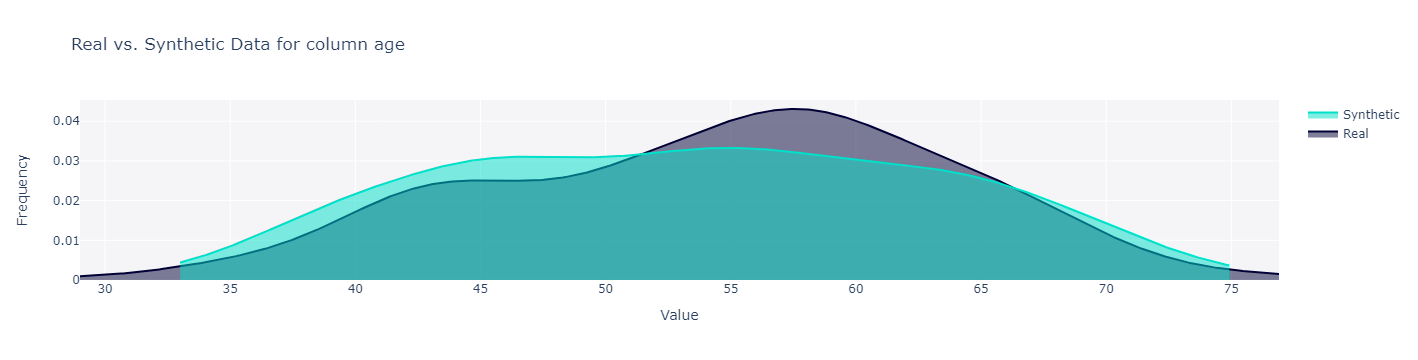

In [217]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=df_synth,
    column_name="age",
    metadata=metadata,
)

fig.show()

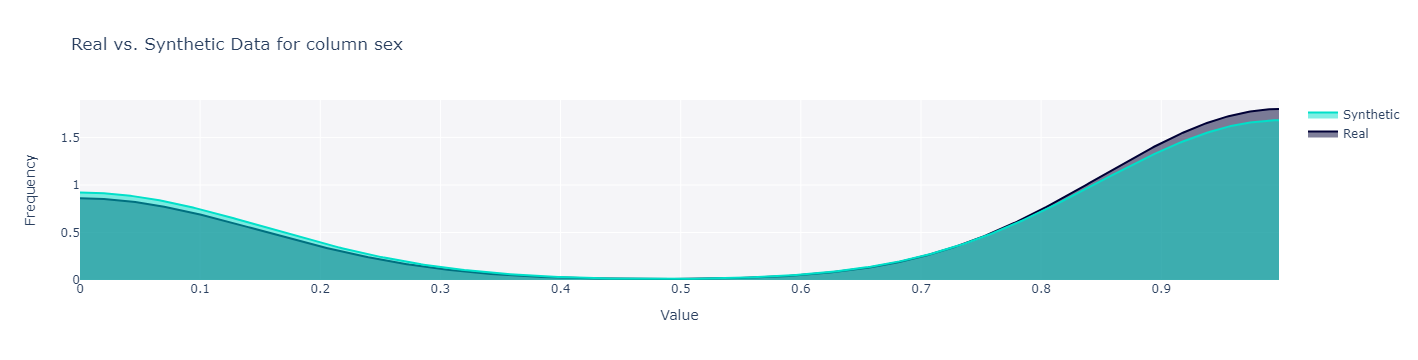

In [218]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=df_synth,
    column_name="sex",
    metadata=metadata,
)

fig.show()

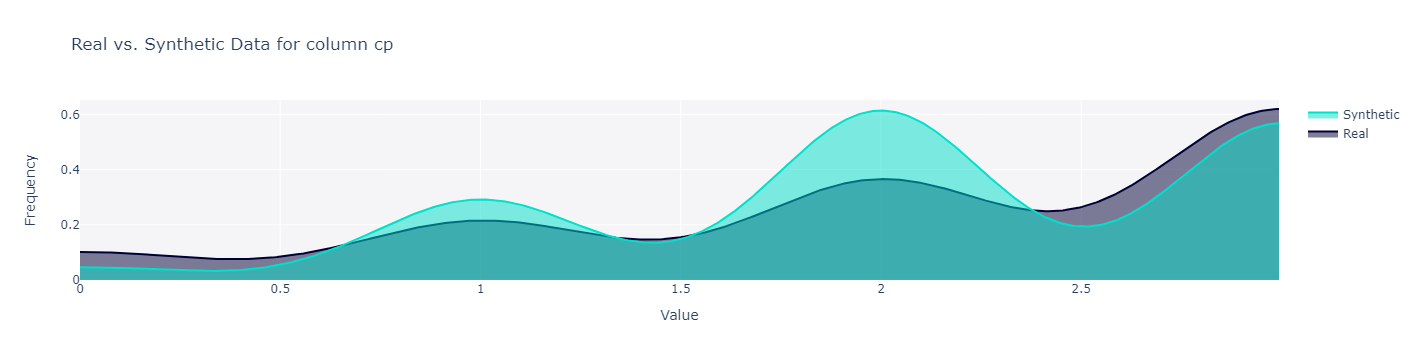

In [219]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=df_synth,
    column_name="cp",
    metadata=metadata,
)

fig.show()

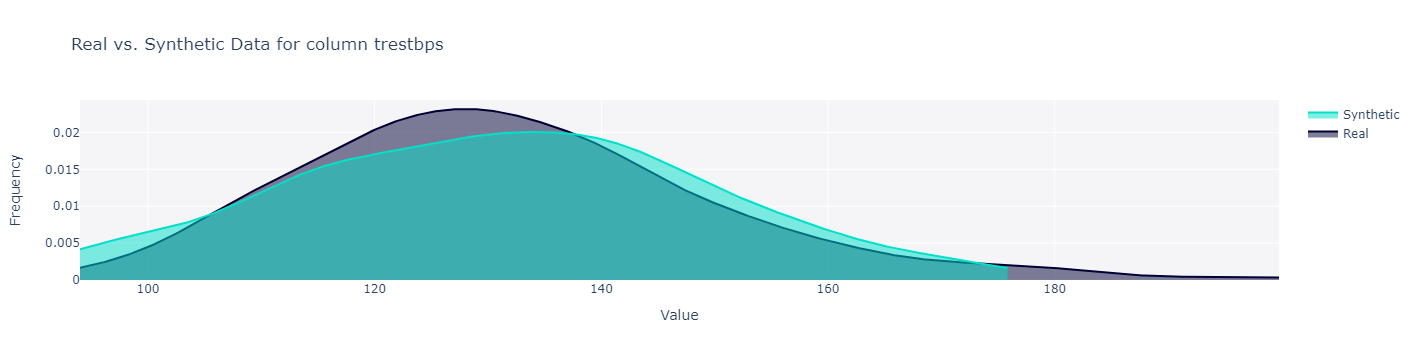

In [220]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=df_synth,
    column_name="trestbps",
    metadata=metadata,
)

fig.show()

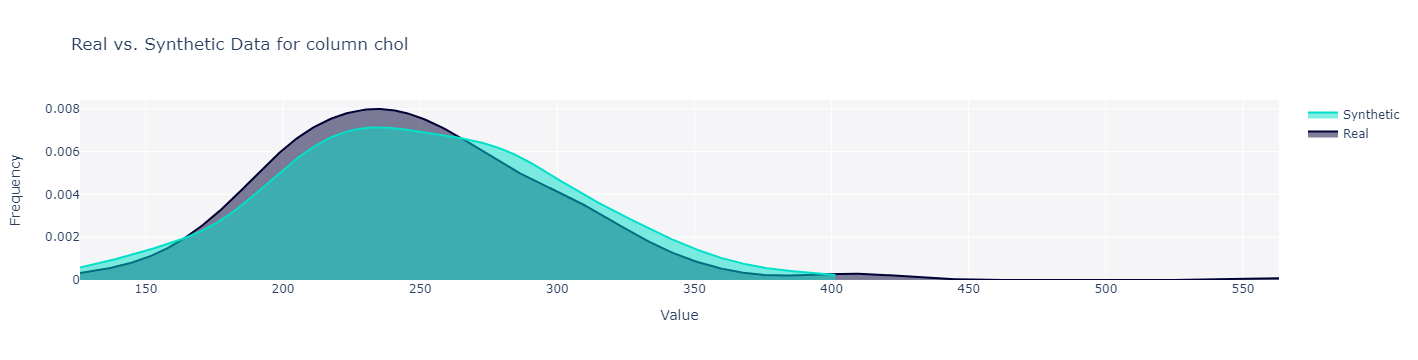

In [221]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=df_synth,
    column_name="chol",
    metadata=metadata,
)

fig.show()

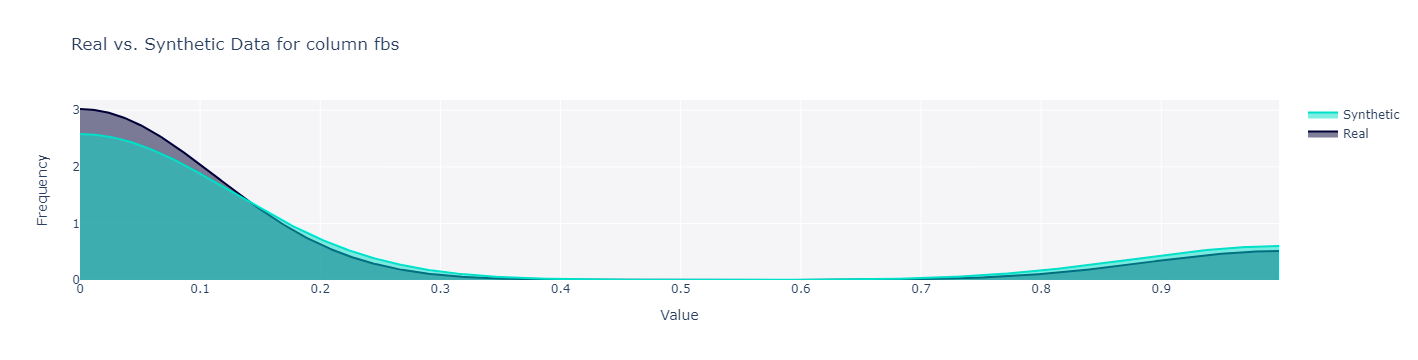

In [222]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=df_synth,
    column_name="fbs",
    metadata=metadata,
)

fig.show()

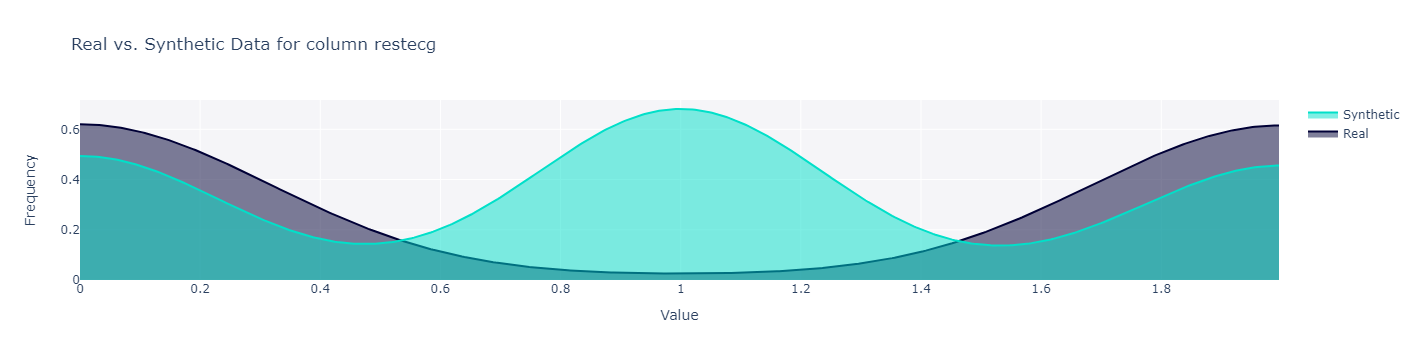

In [223]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=df_synth,
    column_name="restecg",
    metadata=metadata,
)

fig.show()

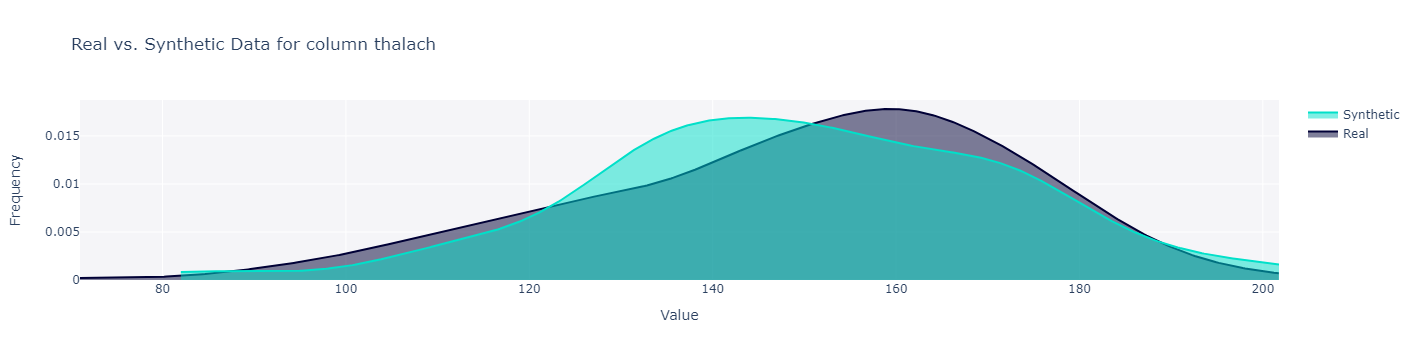

In [224]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=df_synth,
    column_name="thalach",
    metadata=metadata,
)

fig.show()

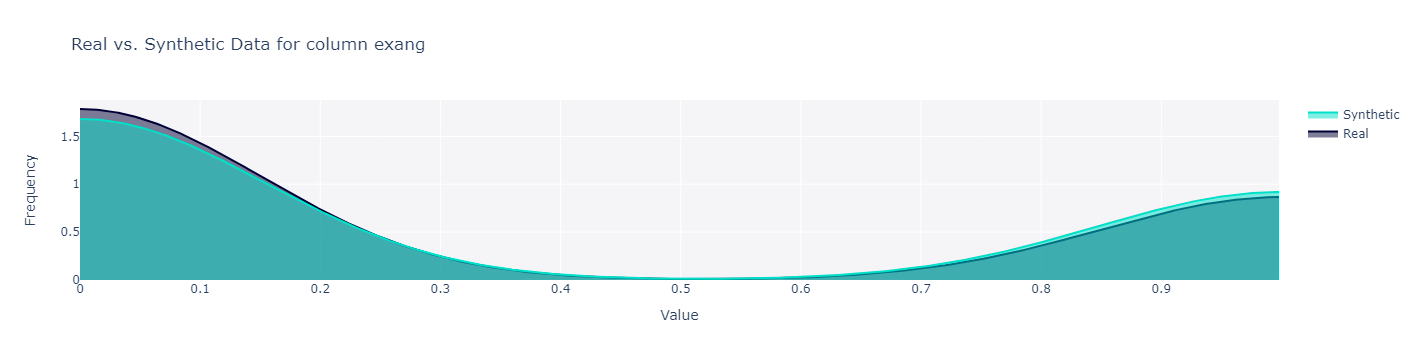

In [225]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=df_synth,
    column_name="exang",
    metadata=metadata,
)

fig.show()

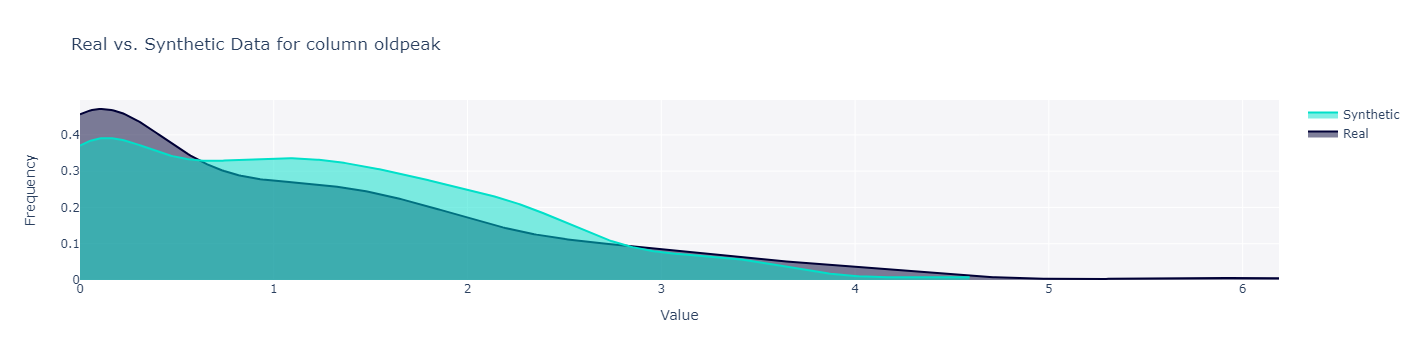

In [226]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=df_synth,
    column_name="oldpeak",
    metadata=metadata,
)

fig.show()

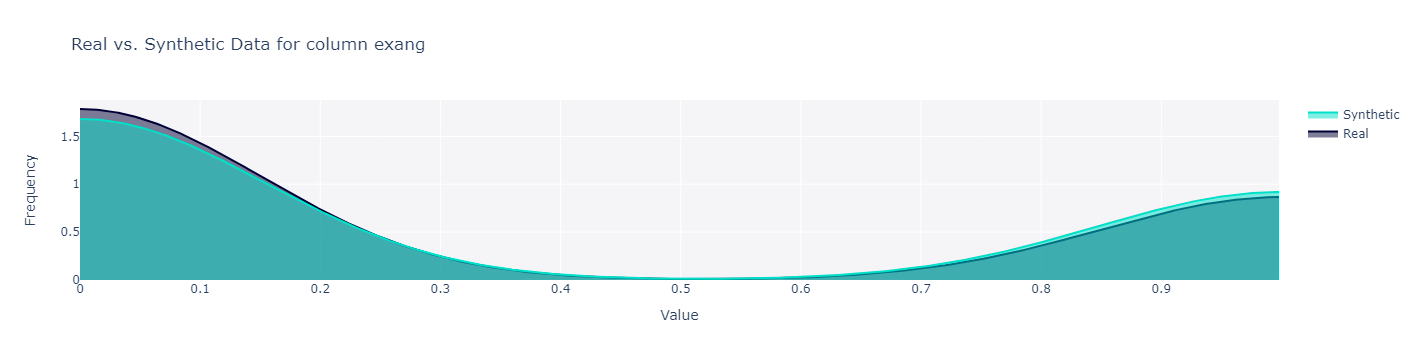

In [227]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=df_synth,
    column_name="exang",
    metadata=metadata,
)

fig.show()

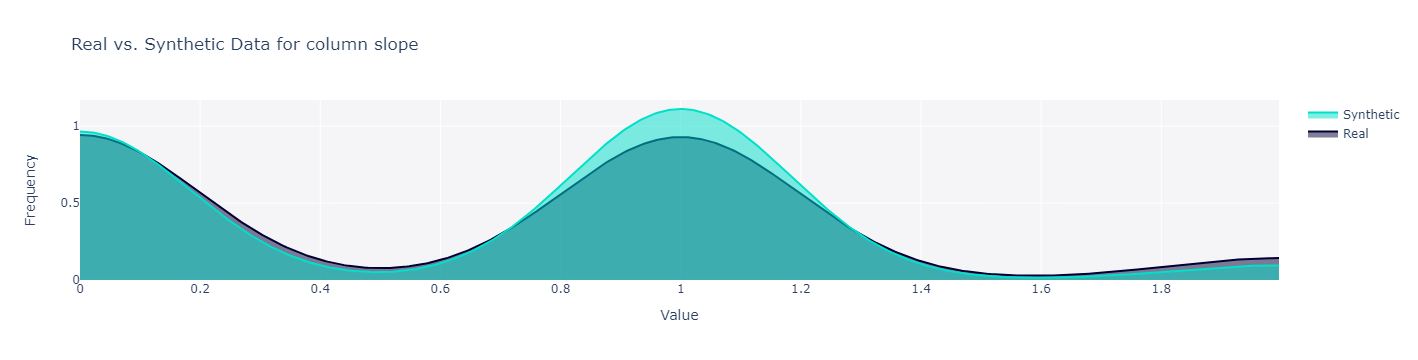

In [228]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=df_synth,
    column_name="slope",
    metadata=metadata,
)

fig.show()

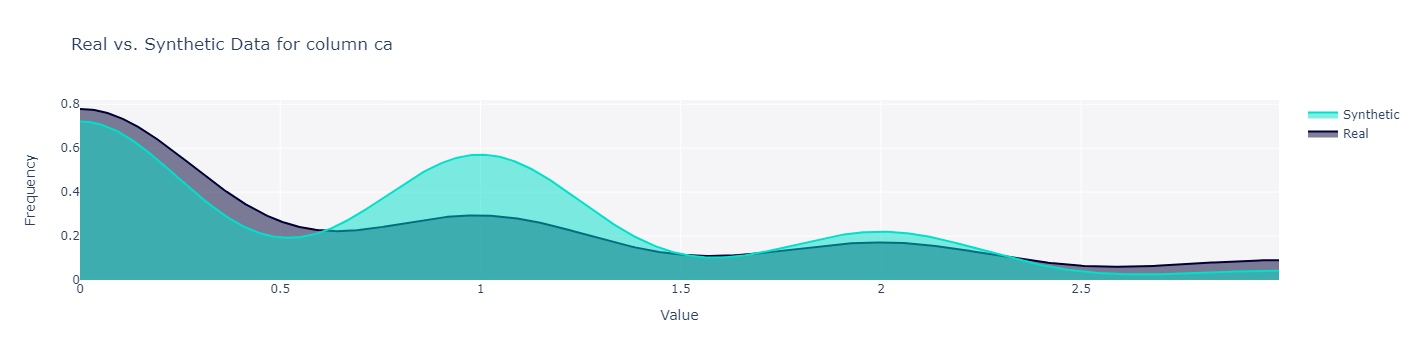

In [229]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=df_synth,
    column_name="ca",
    metadata=metadata,
)

fig.show()

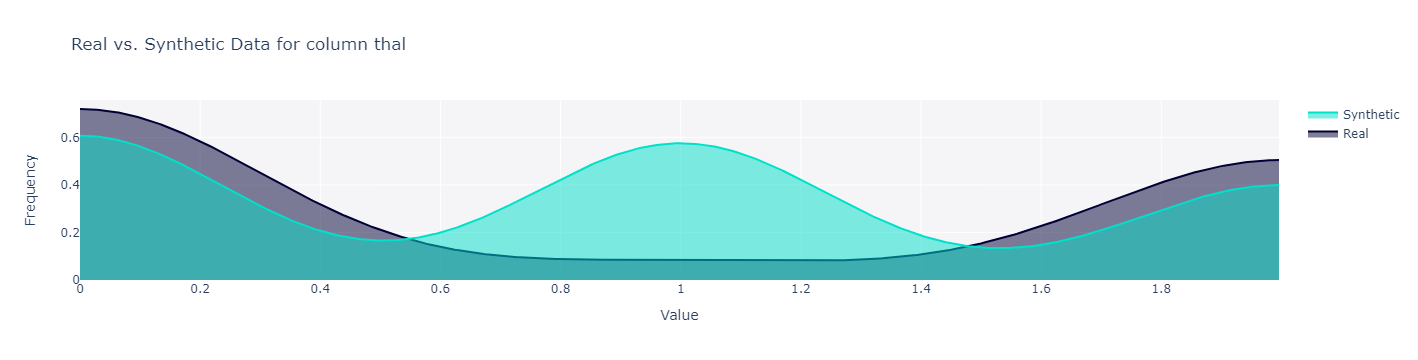

In [230]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=df_synth,
    column_name="thal",
    metadata=metadata,
)

fig.show()

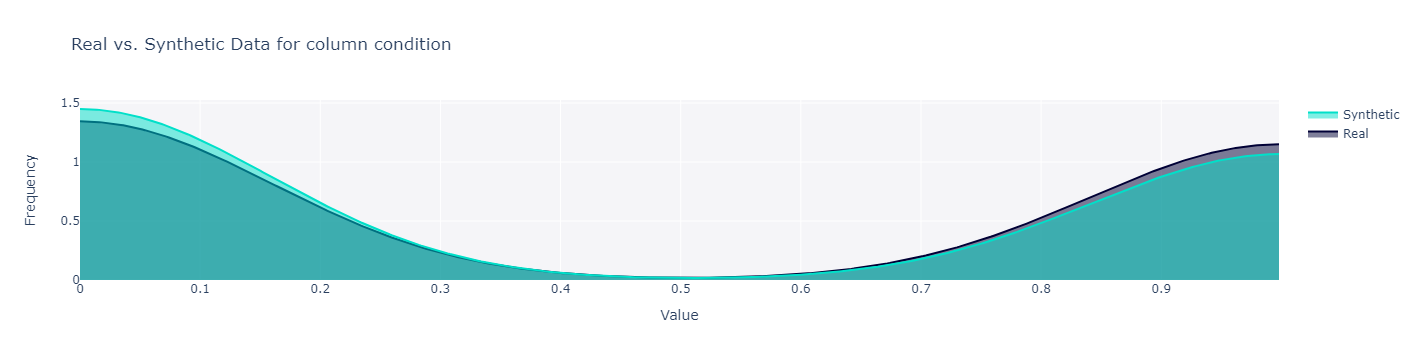

In [231]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=df_synth,
    column_name="condition",
    metadata=metadata,
)

fig.show()

## Processo de Classificação

### Apenas com os Dados Sintéticos

In [148]:
df = df_synth

#### Pre-processamento utilizando OneHotEncoder

In [149]:
cat_features = ["sex", "restecg", "slope", "cp", "exang", "thal", "ca", "fbs"]
num_features = ["age", "oldpeak", "trestbps", "thalach", "chol"]

In [150]:
dummy_variables = dummy(df, cat_features)
df = pd.concat([df] + dummy_variables, axis=1)
df = df.drop(cat_features, axis=1)

In [151]:
df

,age,trestbps,chol,thalach,oldpeak,condition,sex_0,sex_1,restecg_0,restecg_1,...,exang_1,thal_0,thal_1,thal_2,ca_0,ca_1,ca_2,ca_3,fbs_0,fbs_1
0,58,134,205,167,2.3,1,0,1,0,0,...,1,0,1,0,0,1,0,0,1,0
1,39,151,218,168,2.0,0,0,1,0,1,...,0,1,0,0,1,0,0,0,1,0
2,57,163,322,142,0.7,0,1,0,0,1,...,0,0,1,0,0,1,0,0,1,0
3,39,117,227,143,1.3,0,0,1,0,1,...,0,0,1,0,1,0,0,0,1,0
4,47,98,268,163,0.0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,58,148,294,141,1.6,1,1,0,0,1,...,1,1,0,0,1,0,0,0,1,0
293,56,127,228,131,1.5,1,0,1,0,1,...,1,0,0,1,1,0,0,0,0,1
294,54,132,300,156,3.2,1,0,1,0,1,...,1,0,0,1,1,0,0,0,1,0
295,64,116,259,134,0.8,0,1,0,0,1,...,0,0,1,0,0,1,0,0,1,0


#### Divisão Treino e Teste

In [152]:
y = df["condition"]
X = df.drop("condition", axis=1)

In [153]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

In [154]:
print(
    f"X_train: {X_train.shape} \nX_test: {X_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}"
)

X_train: (207, 28) 
X_test: (90, 28) 
y_train: (207,) 
y_test: (90,)


#### Avaliação dos Modelos com Dados Incrementados

In [155]:
results_df = evaluate_models(X_train, X_test, y_train, y_test, standardscaler=False)
print(results_df)

         Classificador  Acurácia  Precisão  F1 Score   ROC/AUC      Tempo  \
0                  SVM  0.744444  0.777778  0.708861  0.740475   0.191612   
1        Decision Tree  0.644444  0.666667  0.578947  0.638793   0.229784   
2                  KNN  0.733333  0.851852  0.657143  0.724889   4.157943   
3        Random Forest  0.733333  0.771429  0.692308  0.728847  14.690856   
4  Logistic Regression  0.744444  0.794118  0.701299  0.739485   0.436126   
5                  MLP  0.766667  0.789474  0.740741  0.763731  14.185583   

                                 Best Parameters  
0                      {'C': 5, 'kernel': 'rbf'}  
1       {'max_depth': 2, 'min_samples_split': 2}  
2      {'n_neighbors': 10, 'weights': 'uniform'}  
3       {'max_depth': None, 'n_estimators': 200}  
4                    {'C': 0.1, 'solver': 'sag'}  
5  {'alpha': 0.01, 'hidden_layer_sizes': (100,)}  


### Incrementação Dados Sintéticos + Reais

In [85]:
df = pd.read_csv("heart_cleveland.csv")

In [86]:
df_new = pd.concat([df, df_synth])
df = df_new
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,60,0,3,147,294,0,1,147,1,1.6,1,0,0,1
293,54,1,3,128,232,1,1,131,1,1.4,1,0,2,1
294,55,1,3,131,298,0,1,157,1,2.9,1,1,2,1
295,66,0,2,110,252,0,1,139,0,1.3,1,1,0,1


#### Pre-processamento utilizando OneHotEncoder

In [87]:
cat_features = ["sex", "restecg", "slope", "cp", "exang", "thal", "ca", "fbs"]
num_features = ["age", "oldpeak", "trestbps", "thalach", "chol"]

In [88]:
dummy_variables = dummy(df, cat_features)
df = pd.concat([df] + dummy_variables, axis=1)
df = df.drop(cat_features, axis=1)

In [89]:
df

,age,trestbps,chol,thalach,oldpeak,condition,sex_0,sex_1,restecg_0,restecg_1,...,exang_1,thal_0,thal_1,thal_2,ca_0,ca_1,ca_2,ca_3,fbs_0,fbs_1
0,69,160,234,131,0.1,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
1,69,140,239,151,1.8,0,1,0,1,0,...,0,1,0,0,0,0,1,0,1,0
2,66,150,226,114,2.6,0,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0
3,65,138,282,174,1.4,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
4,64,110,211,144,1.8,0,0,1,0,0,...,1,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,60,147,294,147,1.6,1,1,0,0,1,...,1,1,0,0,1,0,0,0,1,0
293,54,128,232,131,1.4,1,0,1,0,1,...,1,0,0,1,1,0,0,0,0,1
294,55,131,298,157,2.9,1,0,1,0,1,...,1,0,0,1,0,1,0,0,1,0
295,66,110,252,139,1.3,1,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0


#### Divisão Treino e Teste

In [90]:
y = df["condition"]
X = df.drop("condition", axis=1)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

In [92]:
print(
    f"X_train: {X_train.shape} \nX_test: {X_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}"
)

X_train: (415, 28) 
X_test: (179, 28) 
y_train: (415,) 
y_test: (179,)


#### Avaliação dos Modelos com Dados Incrementados

In [93]:
results_df = evaluate_models(X_train, X_test, y_train, y_test, standardscaler=False)
print(results_df)

         Classificador  Acurácia  Precisão  F1 Score   ROC/AUC      Tempo  \
0                  SVM  0.770950  0.758621  0.682171  0.745044   0.398736   
1        Decision Tree  0.687151  0.605634  0.605634  0.673187   0.268256   
2                  KNN  0.754190  0.721311  0.666667  0.731155   4.800934   
3        Random Forest  0.759777  0.718750  0.681481  0.740610  15.986398   
4  Logistic Regression  0.754190  0.707692  0.676471  0.735981   0.418802   
5                  MLP  0.731844  0.676923  0.647059  0.712637  39.282009   

                                     Best Parameters  
0                        {'C': 0.1, 'kernel': 'rbf'}  
1        {'max_depth': None, 'min_samples_split': 4}  
2           {'n_neighbors': 7, 'weights': 'uniform'}  
3              {'max_depth': 5, 'n_estimators': 300}  
4                   {'C': 10, 'solver': 'liblinear'}  
5  {'alpha': 0.001, 'hidden_layer_sizes': (100, 50)}  
